# Exemplo 10: Redução de Dimensionalidade
## Elementos nutricionais mais importantes

*Redução de dimensionalidade* ou *redução de dimensão* é uma técnica usada em mineração de dados e aprendizado de máquina que tem como objetivo a redução do número de variáveis de entrada para extrair um conjunto de variáveis principais. Apesar do risco de perda de acurácia na análise, a redução do tempo de processamento torna esta técnca importante para a análise de dados multivariáveis. 

Os algoritmos de seleção de atributos tentam encontrar um subconjunto das variáveis de entrada (também chamadas de atributos) mais importante para a análise. A análise de dados como regressão ou classificação pode ser feita no espaço reduzido com mais velocidade e precisão do que no espaço original.

## Singular Value Decomposition (SVD)

A decomposição de valor singular, ou Singular Value Decomposition (SVD), é uma técnica de álgebra linear onde uma matriz A é transformada por fatoração em um produto de três matrizes A = UDV', onde as colunas de U e V' são ortonormais e a matriz D é diagonal com números reais positivas. O SVD é útil em várias tarefas, dentre elas, pode ser usada na redução de dimensionalidade. Diferentemente da decomposição espectral, comumente usada em Álgebra Linear, a decomposição de valor singular pode ser usada para todas as matrizes (retangulares ou quadradas), sendo uma ferramenta útil para análise de dados. A matriz diagonal D representa a relevância de cada atributo e através da seleção dos maiores valores podemos excluir linhas da matrz U e colunas da matriz V', reduzindo a dimensionalidade da matriz.

## Principal Component Analysis (PCA)

A principal técnica linear para redução de dimensionalidade é a análise de componentes principais (PCA). PCA realiza um mapeamento linear dos dados de entrada para um espaço de menor dimensão, de forma que a variação dos dados na representação de dimensão menor seja maximizada. Na prática, a matriz de covariância (e às vezes a de correlação) dos dados é construída e são calculados os autovetores nessa matriz. Os vetores próprios que correspondem aos maiores valores próprios (os componentes principais) que agora podem ser usados para reconstruir uma grande parte da variação dos dados originais. Além disso, os primeiros autovetores podem ser interpretados como termos do comportamento físico do sistema, porque geralmente contribuem com a maior parte da energia do sistema. Uma redução usando o PCA deve ser comprovada caso a caso, pois nem todos os sistemas exibem esse comportamento de equivalencia. O espaço original foi reduzido com perda de dados, mas esperamos manter a variação mais importante para a análise do problema.

## Exemplo

Este exemplo apresenta a redução de dimensionalidade usando SVD e PCA sobre dados nutricionais de alimentos da USDA National Nutrient Database com 45 campos. O objetivo é obter relações dos alimentos através apenas dos principais componente.

## Carregando de bibliotecas 

In [1]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg.distributed import SingularValueDecomposition

import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

import time
start_time = time.time()

# Show graphics inline
%matplotlib inline

## Funções auxiliares

In [2]:
def sliceFeatures(df, nValores, nomeSaidas, nomeEntrada):#dataframe / numero de colunas a serem criadas / nome das colunas de saida / ...coluna de entrada
    for i in range(nValores):
        slicer = VectorSlicer(inputCol = nomeEntrada, outputCol = nomeSaidas + str(i+1), indices=[i])
        df = slicer.transform(df)
    return df

def returnVector(df, name):#dataframe / nome da coluna , retorna um vetor da coluna especificada
    aux = np.array(df.select(name).collect())
    aux2 = []
    for i in range(df.count()):
        aux2.append(float(aux[i]))
    return aux2

def returnDimesion(nAmostras, nTipos, rangeDaMedia):#retorna um vetor np com nAmostras, com nTipos com a mesma media, que varia de 1 a rangeDaMedia 
    d = []
    for k in range(nTipo):
        t = np.random.poisson(lam=rd.randrange(1, rangeDaMedia), size = nAmostras)
        d = np.concatenate((d, t))
    return d   

## Parameters configuration

In [3]:
# Path to dataset file
data_path = './data/'

# Number of principal components
kComp = 6

# Number of components (collumn)
TotalComp = 38

# Set principal component column label
colname = [] 
for i in range(1, kComp+1):
    colname.append("PC"+str(i))

## Creating Spark environment

In [4]:
# Create Spark Session
sc = SparkSession.builder \
     .master("local[*]") \
     .appName("ReducaoDimensionalidade") \
     .getOrCreate()

## Reading Data

In [5]:
# Define Dataframe schema
food_schema = StructType([
    StructField('ID', IntegerType()),
    StructField('FoodGroup', StringType(), True),
    StructField('ShortDescrip', StringType(), True),
    StructField('Descrip', StringType(), True),
    StructField('CommonName', StringType(), True),
    StructField('MfgName', StringType(), True),
    StructField('ScientificName', StringType(), True),
    StructField('Energy_kcal', FloatType(), True),
    StructField('Protein_g', FloatType(), True),
    StructField('Fat_g', FloatType(), True),
    StructField('Carb_g', FloatType(), True),
    StructField('Sugar_g', FloatType(), True),
    StructField('Fiber_g', FloatType(), True),
    StructField('VitA_mcg', FloatType(), True),
    StructField('VitB6_mg', FloatType(), True),
    StructField('VitB12_mcg', FloatType(), True),
    StructField('VitC_mg', FloatType(), True),
    StructField('VitE_mg', FloatType(), True),
    StructField('Folate_mcg', FloatType(), True),
    StructField('Niacin_mg', FloatType(), True),
    StructField('Riboflavin_mg', FloatType(), True),
    StructField('Thiamin_mg', FloatType(), True),
    StructField('Calcium_mg', FloatType(), True),
    StructField('Copper_mcg', FloatType(), True),
    StructField('Iron_mg', FloatType(), True),
    StructField('Magnesium_mg', FloatType(), True),
    StructField('Manganese_mg', FloatType(), True),
    StructField('Phosphorus_mg', FloatType(), True),
    StructField('Selenium_mcg', FloatType(), True),
    StructField('Zinc_mg', FloatType(), True),
    StructField('VitA_USRDA', FloatType(), True),
    StructField('VitB6_USRDA', FloatType(), True),
    StructField('VitB12_USRDA', FloatType(), True),
    StructField('VitC_USRDA', FloatType(), True),
    StructField('VitE_USRDA', FloatType(), True),
    StructField('Folate_USRDA', FloatType(), True),
    StructField('Niacin_USRDA', FloatType(), True),
    StructField('Riboflavin_USRDA', FloatType(), True),
    StructField('Thiamin_USRDA', FloatType(), True),
    StructField('Calcium_USRDA', FloatType(), True),
    StructField('Copper_USRDA', FloatType(), True),
    StructField('Magnesium_USRDA', FloatType(), True),
    StructField('Phosphorus_USRDA', FloatType(), True),
    StructField('Selenium_USRDA', FloatType(), True),
    StructField('Zinc_USRDA', FloatType(), True),
])

#Extrai dados de dados dos alimentos CSV para Dataframe Spark
food = sc.read.format("csv").options(header='true'). \
       load(data_path+"nndb_flat.csv.gz",schema=food_schema)

#food.dtypes
food.show(5)

+----+--------------------+--------------------+--------------------+----------+-------+--------------+-----------+---------+-----+------+-------+-------+--------+--------+----------+-------+-------+----------+---------+-------------+----------+----------+----------+-------+------------+------------+-------------+------------+-------+----------+------------+------------+----------+-----------+------------+------------+----------------+-------------+-------------+------------+---------------+----------------+--------------+------------+
|  ID|           FoodGroup|        ShortDescrip|             Descrip|CommonName|MfgName|ScientificName|Energy_kcal|Protein_g|Fat_g|Carb_g|Sugar_g|Fiber_g|VitA_mcg|VitB6_mg|VitB12_mcg|VitC_mg|VitE_mg|Folate_mcg|Niacin_mg|Riboflavin_mg|Thiamin_mg|Calcium_mg|Copper_mcg|Iron_mg|Magnesium_mg|Manganese_mg|Phosphorus_mg|Selenium_mcg|Zinc_mg|VitA_USRDA| VitB6_USRDA|VitB12_USRDA|VitC_USRDA| VitE_USRDA|Folate_USRDA|Niacin_USRDA|Riboflavin_USRDA|Thiamin_USRDA|Calci

In [6]:
# The feature column should join all parameters as a Vector
# Set the column names that is not part of features list
ignore = ['ID', 'FoodGroup', 'ShortDescrip', 'Descrip', 'CommonName', 'MfgName', 'ScientificName']

# list will be the value of all columns parts of features vector. Save it, it will be used to revert the vector
list = [x for x in food.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
# To avoid errors invalid collumn fields shoud be skiped
data = (assembler.setHandleInvalid("skip").transform(food).select("ID","Descrip","FoodGroup","features"))

print("Final Dataframe")
data.printSchema()

Final Dataframe
root
 |-- ID: integer (nullable = true)
 |-- Descrip: string (nullable = true)
 |-- FoodGroup: string (nullable = true)
 |-- features: vector (nullable = true)



## Normalize the feature vector

In [7]:
# If feature vector use different scale, all collumn should be normalized 
standardScaler = StandardScaler(inputCol="features", outputCol="scalled_features", withStd=True, withMean=True)
scalledmodel = standardScaler.fit(data)

# Remove unscalled feature collumn
scalled_data = scalledmodel.transform(data).drop('features')

scalled_data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Descrip: string (nullable = true)
 |-- FoodGroup: string (nullable = true)
 |-- scalled_features: vector (nullable = true)



## Singular Value Decomposition (SVD)

Singular value decomposition (SVD) factorizes a matrix into three matrices: U, s, and V such that:

A=UsV'

where,

U is an orthonormal matrix, whose columns are called left singular vectors,

s is a diagonal matrix with non-negative diagonals in descending order, whose diagonals are called singular values,

V is an orthonormal matrix, whose columns are called right singular vectors.

In [8]:
# Run SVD

start_time_svd =  time.time()

mat = RowMatrix(scalled_data.rdd.map(lambda v: Vectors.fromML(v.scalled_features)))

# Compute the top k singular values and corresponding singular vectors.
svdmodel = mat.computeSVD(kComp, computeU=True)

U = svdmodel.U       # The U factor is a RowMatrix.
s = svdmodel.s       # The singular values are stored in a local dense vector.
V = svdmodel.V       # The V factor is a local dense matrix.

# $example off$
collected = U.rows.take(10)

print("U factor is:")
for vector in collected:
    print(vector)

print()
print("Singular values are: %s" % s)
val_s = sum(s)

print()
print("V factor is:\n%s" % V)

U factor is:
[-0.006092059127006718,0.0022653264938586274,0.0019116031746546098,0.017382448336450862,0.019951082400128328,0.005442171639039023]
[-0.006079175097593518,0.0023180629950858116,0.001928755962935006,0.017464451855487437,0.01991757996020077,0.005374800879203093]
[-0.006011076032772043,0.0023082739465205547,0.0027121264391177123,0.022307400546586097,0.02570630176880181,0.006405079735627463]
[0.0016726517852801138,0.0009620784823515842,0.015467540578069282,-0.005578490867494757,-0.0028041755249217258,0.004642133252568634]
[0.0018157457709106688,0.001142644375638475,0.020518302166788033,-0.005414019906776366,-0.005591606712410671,0.00466783260433399]
[-3.154077063847744e-05,0.0026001364693825743,0.003909867957973387,-0.004543347863512276,0.004109430210715111,0.0035406411433852878]
[0.0012208159285604554,0.0018276506301469228,0.010518049519432748,-0.0060777061346920114,-0.0019234167745581865,0.004192714231772679]
[0.002403456876881834,0.00028992419494629044,0.02112973072526526,-0

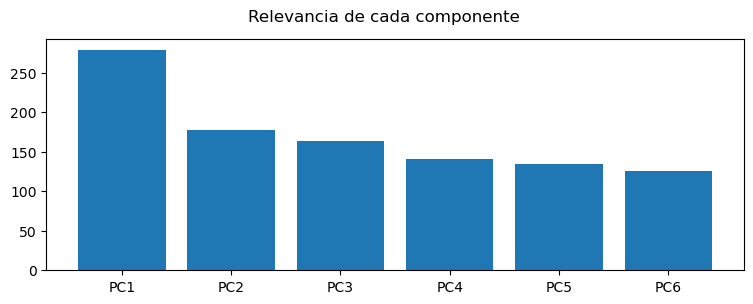

In [9]:
names = colname
values = s

fig, ax = plt.subplots(figsize=(9, 3), sharey=True)
ax.bar(names, values)
fig.suptitle('Relevancia de cada componente')
plt.show()

In [10]:
rows = V.toArray().tolist()
svd_comp = pd.DataFrame(rows, columns = colname, index = list)
print(svd_comp)

time_svd = time.time() - start_time_svd

                       PC1       PC2       PC3       PC4       PC5       PC6
Energy_kcal       0.094956 -0.097068  0.142991  0.268432  0.297146 -0.054701
Protein_g         0.113574  0.084490  0.168156 -0.302393  0.121008  0.079531
Fat_g             0.013720 -0.016785  0.134297  0.225341  0.376630  0.105318
Carb_g            0.107990 -0.177524  0.008018  0.264283 -0.081415 -0.259134
Sugar_g           0.042907 -0.112873 -0.039725  0.254731 -0.058038 -0.168612
Fiber_g           0.116403 -0.116814  0.138458  0.186088 -0.079494 -0.127520
VitA_mcg          0.106931  0.362691 -0.067775  0.184542 -0.094158 -0.008120
VitB6_mg          0.238880 -0.094708 -0.124673 -0.004203 -0.009503  0.152648
VitB12_mcg        0.143692  0.361819 -0.070176  0.002894  0.016997 -0.015107
VitC_mg           0.069862 -0.040587 -0.086629  0.111735 -0.309232  0.490171
VitE_mg           0.099739 -0.067405  0.045537  0.271809  0.343748  0.278738
Folate_mcg        0.212679 -0.120719 -0.164759 -0.002058  0.017874 -0.148829

In [11]:
# Compute the total singular values sum to show importance.
svdmodel = mat.computeSVD(TotalComp, computeU=True)
total_s = sum(svdmodel.s)       
exvar_svd = val_s / total_s

## Principal Component Analysis (PCA)

In [12]:
# Rum PCA algorithm
start_time_pca =  time.time()

# k= number of components to be reduced. PCA find the k most important components
pca = PCA(k=kComp, inputCol="scalled_features", outputCol="pca_features")
pcamodel = pca.fit(scalled_data)
result = pcamodel.transform(scalled_data)

result.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Descrip: string (nullable = true)
 |-- FoodGroup: string (nullable = true)
 |-- scalled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



Relevance of each component
[26.620883 10.777255  9.147146  6.788685  6.22337   5.459254]


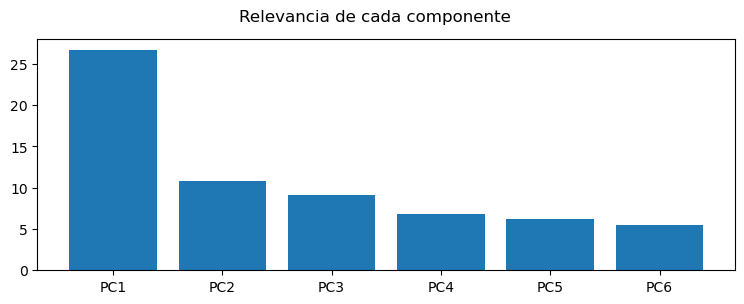

In [13]:
# Show the importance of each component: explainedVariance
pca_var= np.round(100.00*pcamodel.explainedVariance.toArray(),kComp)
exvar_pca = sum(pcamodel.explainedVariance)

print("Relevance of each component")
print(pca_var)

names = colname
values = pca_var

fig, ax = plt.subplots(figsize=(9, 3), sharey=True)
ax.bar(names, values)
fig.suptitle('Relevancia de cada componente')
plt.show()

In [14]:
# List the relevance of each components by element
pcs = np.round(pcamodel.pc.toArray(),4)
pca_comp = pd.DataFrame(pcs, columns = colname, index = list)

print(pca_comp)

                     PC1     PC2     PC3     PC4     PC5     PC6
Energy_kcal      -0.0950  0.0971 -0.1430  0.2684 -0.2971  0.0547
Protein_g        -0.1136 -0.0845 -0.1682 -0.3024 -0.1210 -0.0795
Fat_g            -0.0137  0.0168 -0.1343  0.2253 -0.3766 -0.1053
Carb_g           -0.1080  0.1775 -0.0080  0.2643  0.0814  0.2591
Sugar_g          -0.0429  0.1129  0.0397  0.2547  0.0580  0.1686
Fiber_g          -0.1164  0.1168 -0.1385  0.1861  0.0795  0.1275
VitA_mcg         -0.1069 -0.3627  0.0678  0.1845  0.0942  0.0081
VitB6_mg         -0.2389  0.0947  0.1247 -0.0042  0.0095 -0.1526
VitB12_mcg       -0.1437 -0.3618  0.0702  0.0029 -0.0170  0.0151
VitC_mg          -0.0699  0.0406  0.0866  0.1117  0.3092 -0.4902
VitE_mg          -0.0997  0.0674 -0.0455  0.2718 -0.3437 -0.2787
Folate_mcg       -0.2127  0.1207  0.1648 -0.0021 -0.0179  0.1488
Niacin_mg        -0.2569  0.0731  0.1460 -0.1217 -0.0322 -0.0699
Riboflavin_mg    -0.2590 -0.0199  0.1611 -0.0508  0.0502  0.0122
Thiamin_mg       -0.2047 

In [15]:
# List PCA feature for each food 
result_pca = result.select('Descrip',"pca_features")

result_pca.show(truncate=False)
time_pca = time.time() - start_time_pca

+------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+
|Descrip                                                     |pca_features                                                                                                               |
+------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+
|Butter, salted                                              |[1.6961589673245892,-0.4013064157571459,-0.3119835907890829,2.4439650416007224,-2.6857802271446976,-0.6861674219624501]    |
|Butter, whipped, with salt                                  |[1.6925717792213755,-0.41064877605021133,-0.3147830151417492,2.455494702436437,-2.681270186590809,-0.6776730885127763]     |
|Butter oil, anhydrous                                       |[1.

## Results

In [16]:
print("===============================================================================")
print("====================  Compare Explain Variance and Time =======================")
print()
print("Singular Value Decomposition (SVD):  Representation = %3.2f %%   Time = %3.3f s" % (exvar_svd*100, time_svd))
print("Principal Component Analysis (PCA):  Representation = %3.2f %%   Time = %3.3f s" % (exvar_pca*100, time_pca))
print("===============================================================================")

====================  Compare Explain Variance and Time =======================

Singular Value Decomposition (SVD):  Representation = 45.24 %   Time = 5.401 s
Principal Component Analysis (PCA):  Representation = 65.02 %   Time = 1.564 s


In [17]:
sc.stop()